# **Statistics Lab 52568 - Lab 5 Solution**

First, we read the 2021 Israeli election results, and extract the parties voting data

In [1]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
import io
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


First, we need to mount our local drive to the colab network

In [2]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

Running on CoLab


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading elections 2021 data - ballot and demographics data - eshkol hebrati calcali::
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Saving votes per city 2021.csv to votes per city 2021.csv
Saving votes per ballot 2021.csv to votes per ballot 2021.csv


In [5]:
# Loading elections 2021 data - ballot and demographics data - eshkol hebrati calcali::
if run_in_colab:
    from google.colab import files
    social = files.upload()

Saving eshkol_hevrati_calcali.xlsx to eshkol_hevrati_calcali.xlsx


In [16]:
# Loading elections 2021 elections data:
import io

data_type = "ballot" #"ballot"  # city
if run_in_colab:
    if data_type == "city":
      df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    else:
      df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
else:  # read local file
    if data_type == "ballot":
        df_2021_raw = pd.read_csv(data_path + 'votes per ballot 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
    else:
        df_2021_raw = pd.read_csv(data_path + 'votes per city 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')

if data_type == "ballot":
    # preprocessing of ballot
    df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2021 = df_2021[df_2021.columns[9:-1]] # removing "metadata" columns
else:
    # preprocessing of cities 
    df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2021 = df_2021[df_2021.columns[5:-1]] # removing "metadata" columns
# Dataset is now stored in a Pandas Dataframe

# convert columns with the parties' names:
parties_dict_2021 ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}

df_2021.rename(columns=parties_dict_2021, inplace=True)

We use only the parties which their voting **percentage** 
in a given city is above a % threshold, and we remove the results of 'Maatafot hitzoniot':

In [7]:
# Compute votes share only for parties above a certain threshold 
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

total_votes = parties_votes_percents(df_2021, 0.035)  # total votes for each party
names = total_votes.keys() # largest parties

# Data with only the largest parties:
df_2021 = df_2021[names]
df_2021 = df_2021.drop('מעטפות חיצוניות')
df_2021_raw = df_2021_raw.drop('מעטפות חיצוניות')

df_2021.head(10)

,הליכוד,יש עתיד,שס,כחול לבן,ימינה,עבודה,יהדות התורה,ישראל ביתנו,הציונות הדתית,הרשימה המשותפת,תקוה חדשה,מרצ,רעם
שם ישוב,,,,,,,,,,,,,
אבירים,5,27,1,16,0,47,0,2,2,3,8,31,0
אדירים,84,2,61,3,7,1,4,0,9,0,6,0,0
אושה,24,86,0,37,7,72,0,8,0,3,15,20,0
אחווה,27,37,2,36,4,14,0,3,4,0,8,10,0
איבים,17,0,1,5,4,0,0,0,10,0,0,0,0
אלעריאן,4,0,0,0,0,0,0,0,0,48,0,0,32
אלומות,24,49,1,26,12,45,1,3,2,0,9,31,0
אלוני יצחק,1,6,0,3,1,5,0,0,0,0,6,0,0
אליעד,18,54,0,27,21,46,0,12,8,0,17,11,0


## Question 1: 

#### Function that calculates the new fixing parameter  $v_{ij} = \alpha_i + \beta_j$ , and fixes the given data.




In [9]:
# Correct for voting turnout in cities/ballots using linear regression
def regression_turnout_correction(df, turnout):
    # Preprocess: remove cities/ballots with zero votes:
    good_inds = np.where(np.array(turnout) > 0)
    if np.min(turnout) == 0:
      print("Removed cities with no votes in simulation")
    df = df.iloc[good_inds]
    turnout = turnout.iloc[good_inds]

    bzb = df.sum(axis=1) / turnout # can also be read from outside
    model = sm.OLS(bzb, df).fit() # linear regression WITHOUT intercept
    p = df.sum().div(df.sum().sum())  # votes without correction
    q_hat = p * model.params  # M.coef_ # beta_inv
    q_hat = q_hat / q_hat.sum()  # Normalize
    return p, q_hat, model # beta_inv


# Correct for voting turnout in cities/ballots using linear regression
def regression_alpha_beta_turnout_correction(df, turnout):
    # Preprocess: remove cities/ballots with zero votes:
    good_inds = np.where(np.array(turnout) > 0)
    C = len(good_inds)
    K = df.shape[1]
    if np.min(turnout) == 0:
      print("Removed cities with no votes in simulation")
    df = df.iloc[good_inds]
    turnout = turnout.iloc[good_inds]

    bzb = df.sum(axis=1) / turnout # Get the response vector of total bzb. Can also be read from outside
    # New: Set the large design matrix 
    big_A = np.concatenate( (df.to_numpy(), np.diag(df.sum(axis=1))) , axis=1)
    alpha_beta_model = sm.OLS(bzb, big_A).fit() # linear regression WITHOUT intercept
    
    p = df.sum().div(df.sum().sum())  # votes without correction

    beta_inv_hat = alpha_beta_model.params[:K]  # split 
    alpha_inv_hat = alpha_beta_model.params[K:]
    n_tilde_hat = df.to_numpy() * (np.tile(alpha_inv_hat, (K, 1)).transpose() + np.tile(beta_inv_hat, (C, 1)))
    q_hat = n_tilde_hat.sum(axis=0) / n_tilde_hat.sum() # sum over cities and normalize 
    return p, q_hat, alpha_beta_model # [beta_inv, alpha_inv]    


## Question 2: 
#### Repeat the simulations same as in lab 3, and add to the graphs the estimator with the new fixing parameter




From lab 3: 
Function that recieves the  $\tilde{N}$ and V matrices and samples binomial votes. Afterwards, from the samples data we returns the design matrix.

In [ ]:
def sim_data(N,V):
  new_df = pd.DataFrame(np.random.binomial(N,V))
  new_df.index = df_2021.index
  v = new_df.sum(axis=1)/ N.sum(axis=1)
  return new_df, v

#### Run simulations and apply corrections

Computing  $\tilde{N}$ and $V_i$ for the 3 simulations:

In [ ]:
# Nij~ :
N_tilde = np.array(df_2021.mul(df_2021_raw['בזב'].sum()).div(df_2021_raw['כשרים'].sum()),dtype='int32')

# 3 types of Vi 
v = df_2021_raw['כשרים'].div(df_2021_raw['בזב'])
u = list(np.random.permutation(0.2 + np.array(range(13)) * 0.05))


dim = df_2021.shape
# converting them to the desired shape:
V_v = np.tile(np.array([v]).transpose(), (1, len(names)))
V_u = np.tile(np.array(u), (dim[0],1))

V_u_random = V_u.copy()
for i in range(df_2021.shape[0]):
  V_u_random[i,] = np.random.permutation(u)


A function that calculates the $p$ and the  $\hat{q}$  (after fixing data to 100% votes with $v_i= \frac{kosher_i}{bzb_i}$)

In [ ]:
def turnout_correction(df, fix_param):
  p = parties_votes_percents(df, 0) 
  q_hat = parties_votes_percents(df.div(fix_param, axis = "rows"), 0)
  return q_hat


Multiple simulations function:

In [ ]:
def simulations(iters, N, V):
  K = len(names)
  p_mat = np.zeros([iters, K])
  q_hat = np.zeros([iters, K]) 
  q_hat_reg = np.zeros([iters, K]) 
  q_hat_alpha_beta = np.zeros([iters, K])

  # in every simulation we calculate p and q_hat (after fixing the data)
  for i in range(0, iters):
    print("Running iter:", i+1, " out of ", iters)
    new_df, v = sim_data(N,V)
    q_hat[i,] = turnout_correction(new_df, v)
    p_mat[i,], q_hat_reg[i,] = regression_turnout_correction(new_df, v)[0:2]
    p_mat[i,], q_hat_alpha_beta[i,] = regression_alpha_beta_turnout_correction(new_df, v)[0:2]

  return p_mat, q_hat, q_hat_reg, q_hat_alpha_beta

 Run 50 simulations: (new correction can take more time)


In [ ]:
iters = 50 # number of simulations
q_real = N_tilde.sum(axis=0)/(N_tilde.sum())

sim_v = simulations(iters, N_tilde, V_v)
mean_p_v = np.nanmean(sim_v[0],axis=0)
mean_q_v = np.nanmean(sim_v[1],axis=0)
mean_q_v_beta = np.nanmean(sim_v[2],axis=0)
mean_q_v_alpha_beta = np.nanmean(sim_v[3],axis=0)
std_q_v = np.std(sim_v[1],axis=0) # Compute also standard deviations 
std_q_v_beta = np.std(sim_v[2],axis=0)
std_q_v_alpha_beta = np.std(sim_v[3],axis=0)

sim_u = simulations(iters, N_tilde, V_u)
mean_p_u = sim_u[0].mean(axis=0) 
mean_q_u = sim_u[1].mean(axis=0) 
mean_q_u_beta = sim_u[2].mean(axis=0)
mean_q_u_alpha_beta = sim_u[3].mean(axis=0)
std_q_u = sim_u[1].std(axis=0) 
std_q_u_beta = sim_u[2].std(axis=0)
std_q_u_alpha_beta = sim_u[3].std(axis=0)

sim_u_random = simulations(iters, N_tilde, V_u_random)
mean_p_u_random = sim_u_random[0].mean(axis=0)
mean_q_u_random = sim_u_random[1].mean(axis=0)
mean_q_u_random_beta = sim_u_random[2].mean(axis=0)
mean_q_u_random_alpha_beta = sim_u_random[3].mean(axis=0)
std_q_u_random = sim_u_random[1].std(axis=0)
std_q_u_random_beta = sim_u_random[2].std(axis=0)
std_q_u_random_alpha_beta = sim_u_random[3].std(axis=0)


Running iter: 1  out of  50
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Running iter: 2  out of  50
Running iter: 3  out of  50
Running iter: 4  out of  50
Running iter: 5  out of  50
Running iter: 6  out of  50
Running iter: 7  out of  50
Running iter: 8  out of  50
Running iter: 9  out of  50
Running iter: 10  out of  50
Running iter: 11  out of  50
Running iter: 12  out of  50
Running iter: 13  out of  50
Running iter: 14  out of  50
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Running iter: 15  out of  50
Running iter: 16  out of  50
Running iter: 17  out of  50
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Running iter: 18  out of  50
Running iter: 19  out of  50
Running iter: 20  out of  50
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Running iter: 21  out of  50
Running iter: 22  out of  50
Running iter: 23  out of  5

## Bar-plots showing the results

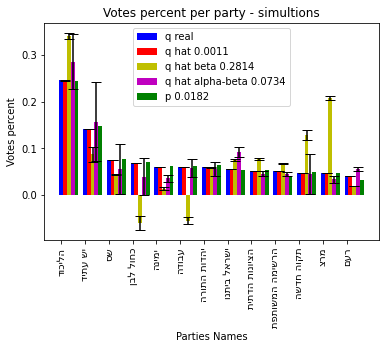

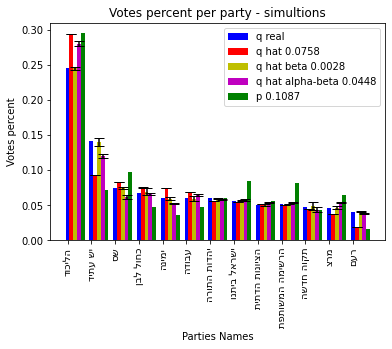

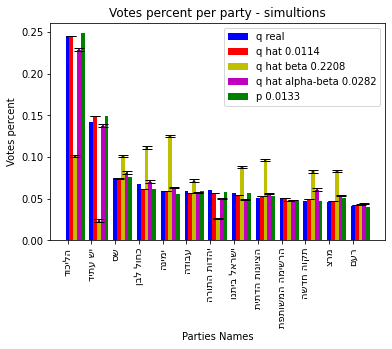

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5a4b92fb10>)

In [ ]:
# Bar plot for a party, only showing values above a certain threshold after fixing:
def party_bar_fix(q_real, q_hat, q_hat_beta, q_hat_alpha_beta, q_hat_std, q_hat_beta_std, q_hat_alpha_beta_std, p):
    width = 0.16  # set column width 
    n = len(total_votes)

    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots()  # plt.subplots()

    # Compute mse: 
    q_hat_rmse = round(np.sqrt(sum((q_hat - q_real)**2)), 4)
    q_hat_beta_rmse = round(np.sqrt(sum((q_hat_beta - q_real)**2)), 4)
    q_hat_alpha_beta_rmse = round(np.sqrt(sum((q_hat_alpha_beta - q_real)**2)), 4)
    p_rmse = round(np.sqrt(sum((p - q_real)**2)), 4)  # no correction at all

    q_real_bar = ax.bar(np.arange(n), list(q_real), width, color='b')
    q_hat_bar = ax.bar(np.arange(n)+width, q_hat, width, color='r', yerr = q_hat_std, capsize=5)
    q_hat_beta_bar = ax.bar(np.arange(n)+2*width, q_hat_beta, width, color='y', yerr = q_hat_beta_std, capsize=5)
    q_hat_alpha_beta_bar = ax.bar(np.arange(n)+3*width, q_hat_alpha_beta, width, color='m', yerr = q_hat_alpha_beta_std, capsize=5)
    p_bar = ax.bar(np.arange(n)+4*width, p, width, color='g')

    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    ax.set_title('Votes percent per party - simultions')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(rev_names, rotation=90)
    ax.legend((q_real_bar, q_hat_bar, q_hat_beta_bar, q_hat_alpha_beta_bar, p_bar), ('q real', 'q hat ' + str(q_hat_rmse), 'q hat beta '  + str(q_hat_beta_rmse), 'q hat alpha-beta ' +  str(q_hat_alpha_beta_rmse), 'p ' + str(p_rmse)))
    plt.show()

    return fig, ax

party_bar_fix(q_real, mean_q_v, mean_q_v_beta, mean_q_v_alpha_beta, std_q_v, std_q_v_beta, std_q_v_alpha_beta, mean_p_v)
party_bar_fix(q_real, mean_q_u, mean_q_u_beta, mean_q_u_alpha_beta, std_q_u, std_q_u_beta, std_q_u_alpha_beta, mean_p_u)
party_bar_fix(q_real, mean_q_u_random, mean_q_u_random_beta, mean_q_u_random_alpha_beta, std_q_u_random, std_q_u_random_beta, std_q_u_random_alpha_beta, mean_p_u_random)

## Question 3: PCA on parties

a.




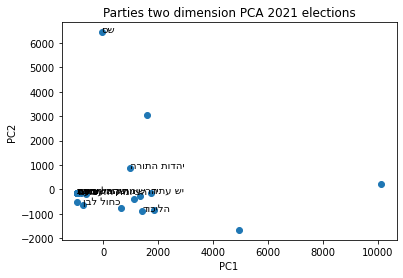

In [17]:
# Show PCA plot for cities in 2021  elections
pca = PCA(n_components=2)  # define PCA object

X_pca_1 = pca.fit_transform(df_2021.T)  # Perform PCA transformation
fig, ax = plt.subplots()
ax.scatter(X_pca_1[:, 0], X_pca_1[:, 1])
ax.set_title('Parties two dimension PCA 2021 elections')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

for i in range(len(names)):
    ax.annotate(names[i][::-1], (X_pca_1[i,0], X_pca_1[i,1]))

plt.show()



b. after normalizing the columns - 

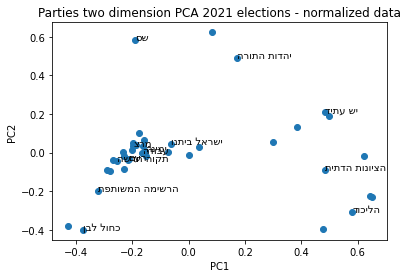

In [18]:

# normalize data - 
df_2021_norm = normalize(df_2021, axis=0) # normalize the columns

X_pca_2 = pca.fit_transform(df_2021_norm.T)  # Perform PCA transformation
fig, ax = plt.subplots()
ax.scatter(X_pca_2[:, 0], X_pca_2[:, 1])
ax.set_title('Parties two dimension PCA 2021 elections - normalized data')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

for i in range(len(names)):
    ax.annotate(names[i][::-1], (X_pca_2[i,0], X_pca_2[i,1]))

plt.show()



## Question 4: PCA on ballots

a. Coloring by the socio-economic level

In [20]:
if  run_in_colab:
    #df_city_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_socio= pd.read_excel(io.BytesIO(social['eshkol_hevrati_calcali.xlsx']), index_col='name')
else:
    #df_city_raw = pd.read_csv(data_path + 'votes per city 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_socio= pd.read_excel('eshkol_hevrati_calcali.xlsx', index_col='name')

df_2021_raw = df_2021_raw[df_2021_raw.columns[0:-1]]
# Create a merged data frame by using the pandas join command:
merged_df = df_2021_raw.join(df_socio.set_index('set_code'), on='סמל ישוב')

merged_df = merged_df.dropna()

# convert columns with the parties' names:
merged_df.rename(columns=parties_dict_2021, inplace=True)
merged_df.head(5)

,סמל ועדה,ברזל,סמל ישוב,קלפי,ריכוז,שופט,בזב,מצביעים,פסולים,כשרים,עבודה,ימינה,יהדות התורה,הרשימה המשותפת,ז,זץ,הציונות הדתית,י,יז,ינ,יף,יק,יר,כ,כך,כחול לבן,ישראל ביתנו,הליכוד,מרצ,נ,ני,נר,רעם,יש עתיד,ףז,צי,צכ,צף,ץ,ק,קי,קך,קץ,ר,רנ,רף,רק,שס,תקוה חדשה,population,index_value,eco_level
שם ישוב,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
אבירים,6,3238,1220,1.0,1,0,221,151,1,150,47,0,0,3,0,0,2,0,3,0,0,0,0,0,0,16,2,5,31,0,0,0,0,27,0,0,0,0,0,0,0,0,0,5,0,0,0,1,8,194.0,0.734,7.0
אדירים,5,1788,113,1.0,1,0,234,180,0,180,1,7,4,0,0,0,9,0,1,0,0,0,0,0,0,3,0,84,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,61,6,267.0,0.011,5.0
אושה,8,4113,278,1.0,1,0,382,276,0,276,72,7,0,3,0,0,0,0,2,0,0,1,0,0,0,37,8,24,20,0,0,0,0,86,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15,462.0,0.873,7.0
אחווה,17,10449,1157,1.0,1,0,183,145,0,145,14,4,0,0,0,0,4,0,0,0,0,0,0,0,0,36,3,27,10,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,159.0,1.085,8.0
איבים,17,10450,338,1.0,1,0,138,40,0,40,0,4,0,0,0,1,10,0,0,0,0,0,0,0,0,5,0,17,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,277.0,-2.401,1.0


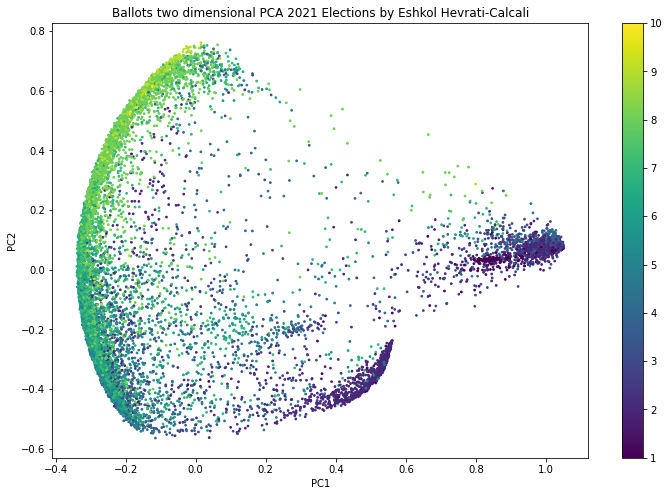

In [21]:
merged_pca = merged_df[names]
# normalize data - # Here the question asked to normalize to L2-norm 1, but normalization to sum 1 is more sensible
merged_pca_norm = normalize(merged_pca.T, axis=0)

color = merged_df['eco_level']
X_pca_3 = pca.fit_transform(merged_pca_norm.T)  # Perform PCA transformation
fig, ax = plt.subplots(figsize=(12,8))
sc = ax.scatter(X_pca_3[:, 0], X_pca_3[:, 1], c = color, cmap='viridis', s = 3)
ax.set_title('Ballots two dimensional PCA 2021 Elections by Eshkol Hevrati-Calcali')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.colorbar(sc)


plt.show()


b. For the 13 largest parties (coloring by support level)

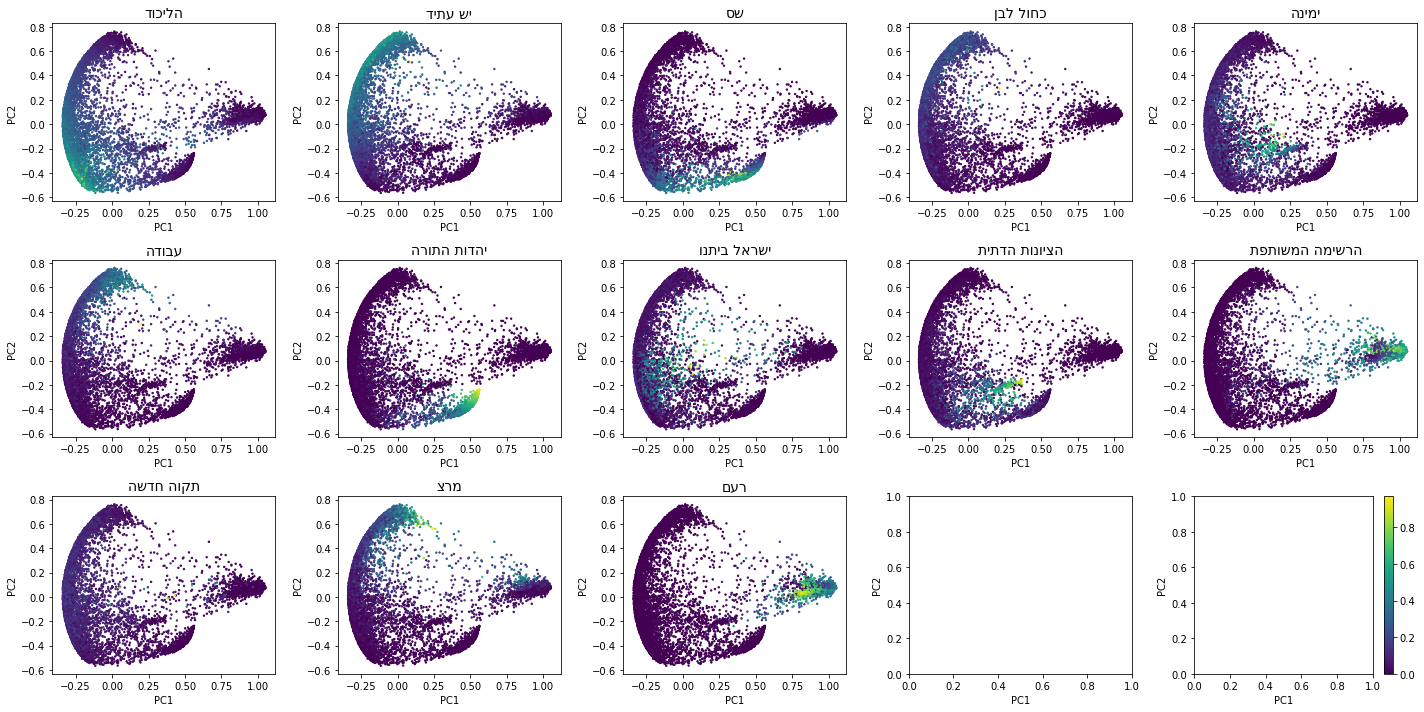

In [22]:

fig, ax = plt.subplots(3, 5, figsize=(20,10))

for i in range(len(names)): 
  party = names[i]
  color = merged_df[party].div(merged_df['כשרים'])   
  sc = ax[i//5, i%5].scatter(X_pca_3[:, 0], X_pca_3[:, 1], c = color, s = 2)  # cmap='viridis', 
  ax[i//5, i%5].set_title(party[::-1], fontsize=14)
plt.colorbar(sc)
  

for ax in ax.flat:
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  
plt.tight_layout()
plt.show()

